<a href="https://colab.research.google.com/github/Harsh-Prajapati54/PyTorch-Learning-Journey/blob/master/06_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Recurrent Neural Network  

setting Device agonostic

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

# Training RNNs

## Forecasting a time series data  

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def download_and_extract_ridership_data():
    tarball_path = Path("datasets/ridership.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/ridership.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")

download_and_extract_ridership_data()

we have downloaded an data for training RNNs the dataset is bout train transit and passenger detail of a train station

In [ ]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head(10)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356
2001-01-07,U,375831,169825
2001-01-08,W,985221,590706
2001-01-09,W,978377,599905


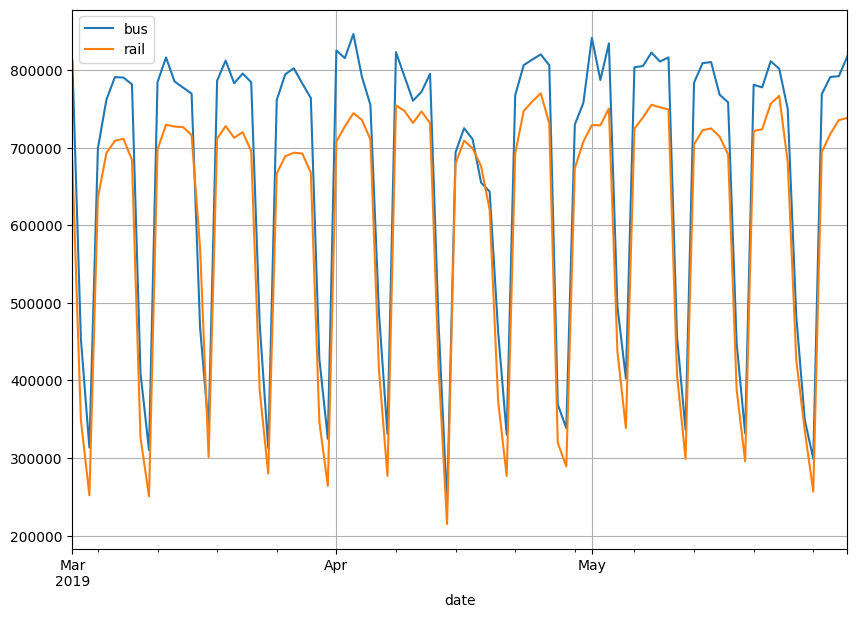

In [ ]:
df["2019-03":"2019-05"].plot(grid = True , figsize= (10,7))
plt.show()

this graph contain data for both `train` and `bus` we can see that a similar pattern is clearly repeated every week.

naive fore cast ing: sim ply
copy ing a past value to make our fore cast. Naive fore cast ing is of ten a great base line, and it can even be
tricky to beat in some cases

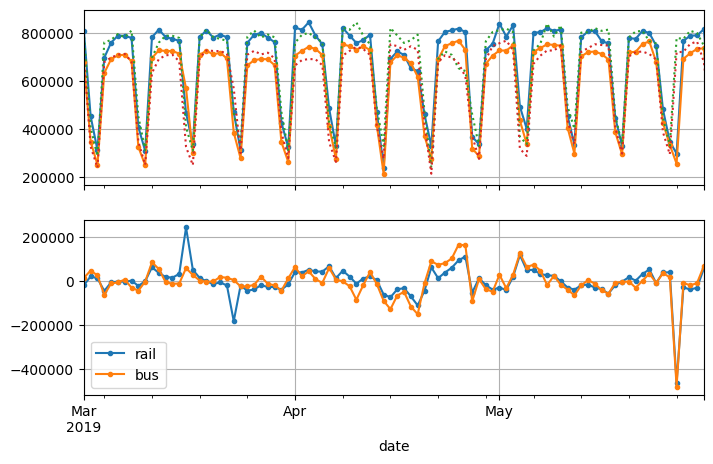

In [ ]:
diff_7 = df[["rail","bus"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot

plt.show()

In [ ]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

there was a 3 day holi day  We could use this
col umn to im prove our fore casts, but for now let’s just mea sure the mean absolute error over the three-month
period

In [ ]:
diff_7.abs().mean()

,0
rail,42143.271739
bus,43915.608696


Our naive fore casts get a mean ab so lute er ror (MAE) of about 43,916 bus rid ers, and about 42,143 rail riders. It’s hard to tell at a glance how good or bad this is, so let’s put the fore cast errors into perspective by dividing them by the target values

In [ ]:
target = df[["bus","rail"]]["2019-03":"2019-05"]
(diff_7 / target).abs().mean()

,0
bus,0.082938
rail,0.089948
